In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as sp

In [5]:
temp_naut = 320  # degC
temp_ambient = 20  # degC
diameter = 0.02  # meters
thermal_conductivity = 50  # W/mC
heat_transfer_coeff = 100  # W/m^2C
length = 0.05  # meters (L)
distance_step = 0.00625  # meters (deltaX)
distance_range = np.arange(0,length + distance_step,distance_step)

\begin{equation*}
C_1=u_o=T_o-T_∞
\end{equation*}

\begin{equation*}
C_2 = -u_o[\frac{\sinh(mL)+(\frac{\beta}{mk})\cosh(mL)}{\cosh(mL)+(\frac{\beta}{mk})\sinh(mL)}]
\end{equation*}

\begin{equation*}
m=\sqrt\frac{\beta P}{kA}
\end{equation*}

In [6]:
radius = diameter / 2
perimeter = 2*math.pi*radius
area = math.pi * radius**2

In [7]:
m = math.sqrt((heat_transfer_coeff * perimeter)/(thermal_conductivity * area))
C1 = temp_naut - temp_ambient
C2 = -C1 * (((math.sinh(m*length))+((heat_transfer_coeff/(m*thermal_conductivity))*math.cosh(m*length))))/((math.cosh(m*length))+((heat_transfer_coeff/(m*thermal_conductivity))*math.sinh(m*length)))

\begin{equation*}
general\ solution\\ u(x)=C_1\cosh(mx)+C_2\sinh(mx)
\end{equation*}

In [8]:
def thermal_analytical_solution():
    temp_at_distance = []
    for distance in distance_range:
        temp_at_distance.append((C1*math.cosh(m*distance)) + (C2*math.sinh(m*distance)))  # eq 1.2.21
        # temp_at_distance.append(C1 * ((math.cosh(m*(length - distance))+(heat_transfer_coeff/m*thermal_conductivity)*math.sinh(m*(length - distance)))/(math.cosh(m*length)+(heat_transfer_coeff/m*thermal_conductivity)*math.sinh(m*length)))) # eq 1.2.23
    return temp_at_distance

thermal_analytical_solution()

[300.0,
 272.24532749565884,
 248.75002996442507,
 229.1465151202865,
 213.12807900148871,
 200.44410747797352,
 190.89615530418308,
 184.33484137261559,
 180.65751159327107]

In [9]:
analytical_solution_output = thermal_analytical_solution()

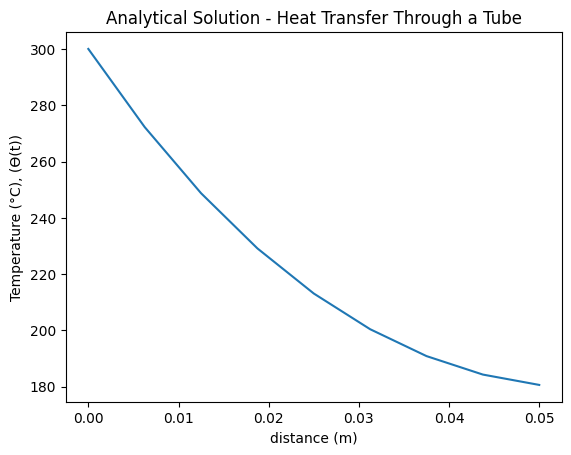

In [10]:
plt.xlabel('distance (m)')
plt.ylabel('Temperature (°C), (ϴ(t))')
plt.title('Analytical Solution - Heat Transfer Through a Tube')
plot_time = np.linspace(0, length, len(analytical_solution_output))
plt.plot(plot_time,analytical_solution_output)

\begin{equation*}
-\frac{d^2\theta}{dx^2} + m^2\theta=0,\ \  m=\sqrt\frac{\beta P}{kA},\ \ 0<x<L
\end{equation*}

In [11]:
# def thermal_numerical_heat_sol_backward_difference():
#     m_series = [m]
#     temp_at_distance = [C1]
    
#     for i in range(1, len(distance_range)):
#         m_series.append(m_series[i-1] - (distance_step * m**2 * temp_at_distance[i-1]))
#         temp_at_distance.append(temp_at_distance[i-1] + (distance_step * m_series[i]))

#     return temp_at_distance

In [15]:
def thermal_numerical_heat_sol_backward_difference(): 
    D = 2 + (m * distance_step)**2
    array = np.array([[D,-1,0,0,0,0,0,0,temp_naut],
                      [-1,D,-1,0,0,0,0,0,0],
                      [0,-1,D,-1,0,0,0,0,0],
                      [0,0,-1,D,-1,0,0,0,0],
                      [0,0,0,-1,D,-1,0,0,0],
                      [0,0,0,0,-1,D,-1,0,0],
                      [0,0,0,0,0,-1,D,-1,0],
                      [0,0,0,0,0,0,-1,1.028125,0]])

    b = array[:, -1]  # Right-hand side of the system of equations
    A = array[:, :-1]  # Coefficient matrix

    # Perform Gaussian elimination
    n = len(b)
    for i in range(n):
        # Find pivot row and swap if necessary
        max_index = np.abs(A[i:, i]).argmax() + i
        if A[max_index, i] == 0:
            raise ValueError("Matrix is singular.")
        if max_index != i:
            A[[i, max_index]] = A[[max_index, i]]
            b[[i, max_index]] = b[[max_index, i]]
        # Reduce rows below pivot
        for j in range(i+1, n):
            ratio = A[j, i] / A[i, i]
            A[j, i:] -= ratio * A[i, i:]
            b[j] -= ratio * b[i]

    # Backsubstitution
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (b[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]

    x_list = x.tolist()
    x_list.insert(0, 300)
    print(x_list)
    return x_list

In [16]:
thermal_numerical_heat_sol_backward_difference()

[300, 289.55551563301566, 263.6353361977972, 241.83445889066925, 223.81224500370809, 209.28709744492983, 198.03206078372864, 189.87127507227316, 184.67722803382193]


[300,
 289.55551563301566,
 263.6353361977972,
 241.83445889066925,
 223.81224500370809,
 209.28709744492983,
 198.03206078372864,
 189.87127507227316,
 184.67722803382193]

In [17]:
numerical_solution_output = thermal_numerical_heat_sol_backward_difference()

[300, 289.55551563301566, 263.6353361977972, 241.83445889066925, 223.81224500370809, 209.28709744492983, 198.03206078372864, 189.87127507227316, 184.67722803382193]


In [18]:
central_error_plot = []
def calculate_error_backward(numerical_solution, analytical_solution):
    for i in range(len(distance_range)):
        central_error_plot.append(abs(numerical_solution[i] - analytical_solution[i])) 
        print( f'error at distance {i*distance_step:.2f} = {abs(numerical_solution[i] - analytical_solution[i]):.5f}')

In [19]:
calculate_error_backward(numerical_solution_output, analytical_solution_output)

error at distance 0.00 = 0.00000
error at distance 0.01 = 17.31019
error at distance 0.01 = 14.88531
error at distance 0.02 = 12.68794
error at distance 0.03 = 10.68417
error at distance 0.03 = 8.84299
error at distance 0.04 = 7.13591
error at distance 0.04 = 5.53643
error at distance 0.05 = 4.01972


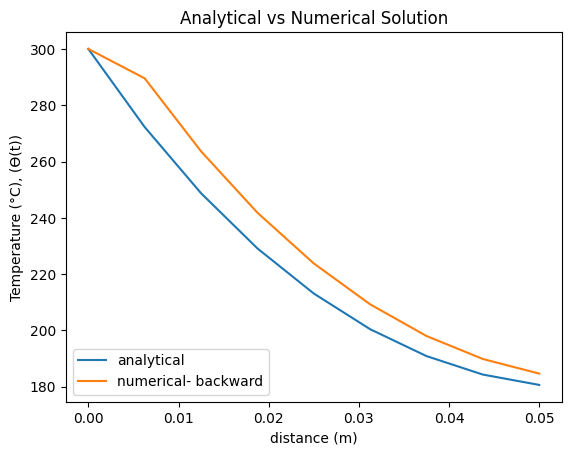

In [20]:
plt.xlabel('distance (m)')
plt.ylabel('Temperature (°C), (ϴ(t))')
plt.title('Analytical vs Numerical Solution')
plot_time = np.linspace(0, length, len(analytical_solution_output))
plt.plot(plot_time,analytical_solution_output,"-" , label='analytical', markersize=3)
plt.plot(plot_time,numerical_solution_output,"-" , label='numerical- backward', markersize=3)
plt.legend(loc="lower left")